<a href="https://colab.research.google.com/github/farhanadhilah/Applied_Deep_Learning/blob/main/10_attention_mechanism.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 10.1. Attention Cues

##10.1.3. Visualization of Attention

In [2]:
!pip install d2l

     |████████████████████████████████| 82 kB 603 kB/s 
     |████████████████████████████████| 9.9 MB 25.1 MB/s 
     |████████████████████████████████| 15.7 MB 45.9 MB/s 
     |████████████████████████████████| 61 kB 4.7 MB/s 
     |████████████████████████████████| 11.2 MB 53.7 MB/s 
     |████████████████████████████████| 930 kB 53.7 MB/s 
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.6
    Uninstalling numpy-1.21.6:
      Successfully uninstalled numpy-1.21.6
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: pandas
    Found existing installation: pandas 1.3.5
    Uninstalling pandas-1.3.5:
      Successfully uninstalled pandas-1.3.5
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.2.2
    Uninstalling matplotlib-3.2.2:
      Successfully uninstalled matplotlib-3.2.2
ERROR: pip's depende

In [3]:
import torch
from d2l import torch as d2l

In [4]:
#@save
def show_heatmaps(matrices, xlabel, ylabel, titles=None, figsize=(2.5, 2.5),
                  cmap='Reds'):
    """Show heatmaps of matrices."""
    d2l.use_svg_display()
    num_rows, num_cols = matrices.shape[0], matrices.shape[1]
    fig, axes = d2l.plt.subplots(num_rows, num_cols, figsize=figsize,
                                 sharex=True, sharey=True, squeeze=False)
    for i, (row_axes, row_matrices) in enumerate(zip(axes, matrices)):
        for j, (ax, matrix) in enumerate(zip(row_axes, row_matrices)):
            pcm = ax.imshow(matrix.detach().numpy(), cmap=cmap)
            if i == num_rows - 1:
                ax.set_xlabel(xlabel)
            if j == 0:
                ax.set_ylabel(ylabel)
            if titles:
                ax.set_title(titles[j])
    fig.colorbar(pcm, ax=axes, shrink=0.6);

In [6]:
!pip install matplotlib==2.2.3

     |████████████████████████████████| 12.6 MB 4.8 MB/s 
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.5.1
    Uninstalling matplotlib-3.5.1:
      Successfully uninstalled matplotlib-3.5.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
plotnine 0.6.0 requires matplotlib>=3.1.1, but you have matplotlib 2.2.3 which is incompatible.
mizani 0.6.0 requires matplotlib>=3.1.1, but you have matplotlib 2.2.3 which is incompatible.
d2l 0.17.5 requires matplotlib==3.5.1, but you have matplotlib 2.2.3 which is incompatible.
arviz 0.12.0 requires matplotlib>=3.0, but you have matplotlib 2.2.3 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


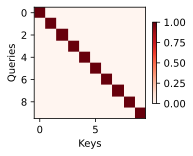

In [7]:
attention_weights = torch.eye(10).reshape((1, 1, 10, 10))
show_heatmaps(attention_weights, xlabel='Keys', ylabel='Queries')

#10.2. Attention Pooling: Nadaraya-Watson Kernel Regression

In [8]:
import torch
from torch import nn
from d2l import torch as d2l

##10.2.1. Generating the Dataset

In [9]:
n_train = 50  # No. of training examples
x_train, _ = torch.sort(torch.rand(n_train) * 5)   # Training inputs

def f(x):
    return 2 * torch.sin(x) + x**0.8

y_train = f(x_train) + torch.normal(0.0, 0.5, (n_train,))  # Training outputs
x_test = torch.arange(0, 5, 0.1)  # Testing examples
y_truth = f(x_test)  # Ground-truth outputs for the testing examples
n_test = len(x_test)  # No. of testing examples
n_test

50

In [10]:
def plot_kernel_reg(y_hat):
    d2l.plot(x_test, [y_truth, y_hat], 'x', 'y', legend=['Truth', 'Pred'],
             xlim=[0, 5], ylim=[-1, 5])
    d2l.plt.plot(x_train, y_train, 'o', alpha=0.5);

##10.2.2. Average Pooling

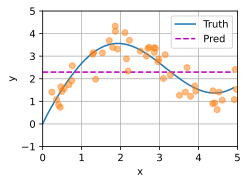

In [11]:
y_hat = torch.repeat_interleave(y_train.mean(), n_test)
plot_kernel_reg(y_hat)

##10.2.3. Nonparametric Attention Pooling

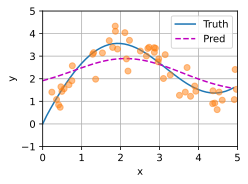

In [13]:
# Shape of `X_repeat`: (`n_test`, `n_train`), where each row contains the
# same testing inputs (i.e., same queries)
X_repeat = x_test.repeat_interleave(n_train).reshape((-1, n_train))
# Note that `x_train` contains the keys. Shape of `attention_weights`:
# (`n_test`, `n_train`), where each row contains attention weights to be
# assigned among the values (`y_train`) given each query
attention_weights = nn.functional.softmax(-(X_repeat - x_train)**2 / 2, dim=1)
# Each element of `y_hat` is weighted average of values, where weights are
# attention weights
y_hat = torch.matmul(attention_weights, y_train)
plot_kernel_reg(y_hat)

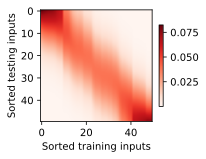

In [14]:
d2l.show_heatmaps(attention_weights.unsqueeze(0).unsqueeze(0),
                  xlabel='Sorted training inputs',
                  ylabel='Sorted testing inputs')

##10.2.4. Parametric Attention Pooling

###10.2.4.1. Batch Matrix Multiplication

In [15]:
X = torch.ones((2, 1, 4))
Y = torch.ones((2, 4, 6))
torch.bmm(X, Y).shape

torch.Size([2, 1, 6])

In [16]:
weights = torch.ones((2, 10)) * 0.1
values = torch.arange(20.0).reshape((2, 10))
torch.bmm(weights.unsqueeze(1), values.unsqueeze(-1))

tensor([[[ 4.5000]],

        [[14.5000]]])

###10.2.4.2. Defining the Model

In [17]:
class NWKernelRegression(nn.Module):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.w = nn.Parameter(torch.rand((1,), requires_grad=True))

    def forward(self, queries, keys, values):
        # Shape of the output `queries` and `attention_weights`:
        # (no. of queries, no. of key-value pairs)
        queries = queries.repeat_interleave(keys.shape[1]).reshape((-1, keys.shape[1]))
        self.attention_weights = nn.functional.softmax(
            -((queries - keys) * self.w)**2 / 2, dim=1)
        # Shape of `values`: (no. of queries, no. of key-value pairs)
        return torch.bmm(self.attention_weights.unsqueeze(1),
                         values.unsqueeze(-1)).reshape(-1)

###10.2.4.3. Training

In [18]:
# Shape of `X_tile`: (`n_train`, `n_train`), where each column contains the
# same training inputs
X_tile = x_train.repeat((n_train, 1))
# Shape of `Y_tile`: (`n_train`, `n_train`), where each column contains the
# same training outputs
Y_tile = y_train.repeat((n_train, 1))
# Shape of `keys`: ('n_train', 'n_train' - 1)
keys = X_tile[(1 - torch.eye(n_train)).type(torch.bool)].reshape((n_train, -1))
# Shape of `values`: ('n_train', 'n_train' - 1)
values = Y_tile[(1 - torch.eye(n_train)).type(torch.bool)].reshape((n_train, -1))

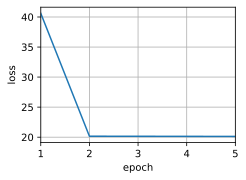

In [19]:
net = NWKernelRegression()
loss = nn.MSELoss(reduction='none')
trainer = torch.optim.SGD(net.parameters(), lr=0.5)
animator = d2l.Animator(xlabel='epoch', ylabel='loss', xlim=[1, 5])

for epoch in range(5):
    trainer.zero_grad()
    l = loss(net(x_train, keys, values), y_train)
    l.sum().backward()
    trainer.step()
    print(f'epoch {epoch + 1}, loss {float(l.sum()):.6f}')
    animator.add(epoch + 1, float(l.sum()))

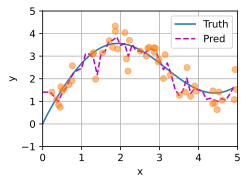

In [20]:
# Shape of `keys`: (`n_test`, `n_train`), where each column contains the same
# training inputs (i.e., same keys)
keys = x_train.repeat((n_test, 1))
# Shape of `value`: (`n_test`, `n_train`)
values = y_train.repeat((n_test, 1))
y_hat = net(x_test, keys, values).unsqueeze(1).detach()
plot_kernel_reg(y_hat)

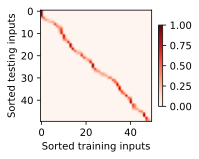

In [21]:
d2l.show_heatmaps(net.attention_weights.unsqueeze(0).unsqueeze(0),
                  xlabel='Sorted training inputs',
                  ylabel='Sorted testing inputs')

#10.3. Attention Scoring Functions

In [22]:
import math
import torch
from torch import nn
from d2l import torch as d2l

##10.3.1. Masked Softmax Operation

In [23]:
#@save
def masked_softmax(X, valid_lens):
    """Perform softmax operation by masking elements on the last axis."""
    # `X`: 3D tensor, `valid_lens`: 1D or 2D tensor
    if valid_lens is None:
        return nn.functional.softmax(X, dim=-1)
    else:
        shape = X.shape
        if valid_lens.dim() == 1:
            valid_lens = torch.repeat_interleave(valid_lens, shape[1])
        else:
            valid_lens = valid_lens.reshape(-1)
        # On the last axis, replace masked elements with a very large negative
        # value, whose exponentiation outputs 0
        X = d2l.sequence_mask(X.reshape(-1, shape[-1]), valid_lens,
                              value=-1e6)
        return nn.functional.softmax(X.reshape(shape), dim=-1)

In [24]:
masked_softmax(torch.rand(2, 2, 4), torch.tensor([2, 3]))

tensor([[[0.4973, 0.5027, 0.0000, 0.0000],
         [0.6932, 0.3068, 0.0000, 0.0000]],

        [[0.2069, 0.2922, 0.5009, 0.0000],
         [0.1853, 0.4031, 0.4116, 0.0000]]])

In [25]:
masked_softmax(torch.rand(2, 2, 4), torch.tensor([[1, 3], [2, 4]]))

tensor([[[1.0000, 0.0000, 0.0000, 0.0000],
         [0.2677, 0.3694, 0.3629, 0.0000]],

        [[0.4908, 0.5092, 0.0000, 0.0000],
         [0.1915, 0.1770, 0.3470, 0.2845]]])

##10.3.2. Additive Attention

In [26]:
#@save
class AdditiveAttention(nn.Module):
    """Additive attention."""
    def __init__(self, key_size, query_size, num_hiddens, dropout, **kwargs):
        super(AdditiveAttention, self).__init__(**kwargs)
        self.W_k = nn.Linear(key_size, num_hiddens, bias=False)
        self.W_q = nn.Linear(query_size, num_hiddens, bias=False)
        self.w_v = nn.Linear(num_hiddens, 1, bias=False)
        self.dropout = nn.Dropout(dropout)

    def forward(self, queries, keys, values, valid_lens):
        queries, keys = self.W_q(queries), self.W_k(keys)
        # After dimension expansion, shape of `queries`: (`batch_size`, no. of
        # queries, 1, `num_hiddens`) and shape of `keys`: (`batch_size`, 1,
        # no. of key-value pairs, `num_hiddens`). Sum them up with
        # broadcasting
        features = queries.unsqueeze(2) + keys.unsqueeze(1)
        features = torch.tanh(features)
        # There is only one output of `self.w_v`, so we remove the last
        # one-dimensional entry from the shape. Shape of `scores`:
        # (`batch_size`, no. of queries, no. of key-value pairs)
        scores = self.w_v(features).squeeze(-1)
        self.attention_weights = masked_softmax(scores, valid_lens)
        # Shape of `values`: (`batch_size`, no. of key-value pairs, value
        # dimension)
        return torch.bmm(self.dropout(self.attention_weights), values)

In [27]:
queries, keys = torch.normal(0, 1, (2, 1, 20)), torch.ones((2, 10, 2))
# The two value matrices in the `values` minibatch are identical
values = torch.arange(40, dtype=torch.float32).reshape(1, 10, 4).repeat(
    2, 1, 1)
valid_lens = torch.tensor([2, 6])

attention = AdditiveAttention(key_size=2, query_size=20, num_hiddens=8,
                              dropout=0.1)
attention.eval()
attention(queries, keys, values, valid_lens)

tensor([[[ 2.0000,  3.0000,  4.0000,  5.0000]],

        [[10.0000, 11.0000, 12.0000, 13.0000]]], grad_fn=<BmmBackward0>)

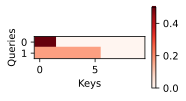

In [28]:
d2l.show_heatmaps(attention.attention_weights.reshape((1, 1, 2, 10)),
                  xlabel='Keys', ylabel='Queries')

##10.3.3. Scaled Dot-Product Attention

In [29]:
#@save
class DotProductAttention(nn.Module):
    """Scaled dot product attention."""
    def __init__(self, dropout, **kwargs):
        super(DotProductAttention, self).__init__(**kwargs)
        self.dropout = nn.Dropout(dropout)

    # Shape of `queries`: (`batch_size`, no. of queries, `d`)
    # Shape of `keys`: (`batch_size`, no. of key-value pairs, `d`)
    # Shape of `values`: (`batch_size`, no. of key-value pairs, value
    # dimension)
    # Shape of `valid_lens`: (`batch_size`,) or (`batch_size`, no. of queries)
    def forward(self, queries, keys, values, valid_lens=None):
        d = queries.shape[-1]
        # Set `transpose_b=True` to swap the last two dimensions of `keys`
        scores = torch.bmm(queries, keys.transpose(1,2)) / math.sqrt(d)
        self.attention_weights = masked_softmax(scores, valid_lens)
        return torch.bmm(self.dropout(self.attention_weights), values)

In [30]:
queries = torch.normal(0, 1, (2, 1, 2))
attention = DotProductAttention(dropout=0.5)
attention.eval()
attention(queries, keys, values, valid_lens)

tensor([[[ 2.0000,  3.0000,  4.0000,  5.0000]],

        [[10.0000, 11.0000, 12.0000, 13.0000]]])

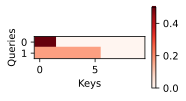

In [31]:
d2l.show_heatmaps(attention.attention_weights.reshape((1, 1, 2, 10)),
                  xlabel='Keys', ylabel='Queries')

#10.4. Bahdanau Attention

##10.4.1. Model

In [32]:
import torch
from torch import nn
from d2l import torch as d2l

##10.4.2. Defining the Decoder with Attention

In [33]:
#@save
class AttentionDecoder(d2l.Decoder):
    """The base attention-based decoder interface."""
    def __init__(self, **kwargs):
        super(AttentionDecoder, self).__init__(**kwargs)

    @property
    def attention_weights(self):
        raise NotImplementedError

In [34]:
class Seq2SeqAttentionDecoder(AttentionDecoder):
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
                 dropout=0, **kwargs):
        super(Seq2SeqAttentionDecoder, self).__init__(**kwargs)
        self.attention = d2l.AdditiveAttention(
            num_hiddens, num_hiddens, num_hiddens, dropout)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.GRU(
            embed_size + num_hiddens, num_hiddens, num_layers,
            dropout=dropout)
        self.dense = nn.Linear(num_hiddens, vocab_size)

    def init_state(self, enc_outputs, enc_valid_lens, *args):
        # Shape of `outputs`: (`num_steps`, `batch_size`, `num_hiddens`).
        # Shape of `hidden_state[0]`: (`num_layers`, `batch_size`,
        # `num_hiddens`)
        outputs, hidden_state = enc_outputs
        return (outputs.permute(1, 0, 2), hidden_state, enc_valid_lens)

    def forward(self, X, state):
        # Shape of `enc_outputs`: (`batch_size`, `num_steps`, `num_hiddens`).
        # Shape of `hidden_state[0]`: (`num_layers`, `batch_size`,
        # `num_hiddens`)
        enc_outputs, hidden_state, enc_valid_lens = state
        # Shape of the output `X`: (`num_steps`, `batch_size`, `embed_size`)
        X = self.embedding(X).permute(1, 0, 2)
        outputs, self._attention_weights = [], []
        for x in X:
            # Shape of `query`: (`batch_size`, 1, `num_hiddens`)
            query = torch.unsqueeze(hidden_state[-1], dim=1)
            # Shape of `context`: (`batch_size`, 1, `num_hiddens`)
            context = self.attention(
                query, enc_outputs, enc_outputs, enc_valid_lens)
            # Concatenate on the feature dimension
            x = torch.cat((context, torch.unsqueeze(x, dim=1)), dim=-1)
            # Reshape `x` as (1, `batch_size`, `embed_size` + `num_hiddens`)
            out, hidden_state = self.rnn(x.permute(1, 0, 2), hidden_state)
            outputs.append(out)
            self._attention_weights.append(self.attention.attention_weights)
        # After fully-connected layer transformation, shape of `outputs`:
        # (`num_steps`, `batch_size`, `vocab_size`)
        outputs = self.dense(torch.cat(outputs, dim=0))
        return outputs.permute(1, 0, 2), [enc_outputs, hidden_state,
                                          enc_valid_lens]

    @property
    def attention_weights(self):
        return self._attention_weights

In [35]:
encoder = d2l.Seq2SeqEncoder(vocab_size=10, embed_size=8, num_hiddens=16,
                             num_layers=2)
encoder.eval()
decoder = Seq2SeqAttentionDecoder(vocab_size=10, embed_size=8, num_hiddens=16,
                                  num_layers=2)
decoder.eval()
X = torch.zeros((4, 7), dtype=torch.long)  # (`batch_size`, `num_steps`)
state = decoder.init_state(encoder(X), None)
output, state = decoder(X, state)
output.shape, len(state), state[0].shape, len(state[1]), state[1][0].shape

(torch.Size([4, 7, 10]), 3, torch.Size([4, 7, 16]), 2, torch.Size([4, 16]))

##10.4.3. Training

loss 0.020, 4023.4 tokens/sec on cpu


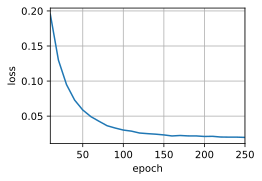

In [36]:
embed_size, num_hiddens, num_layers, dropout = 32, 32, 2, 0.1
batch_size, num_steps = 64, 10
lr, num_epochs, device = 0.005, 250, d2l.try_gpu()

train_iter, src_vocab, tgt_vocab = d2l.load_data_nmt(batch_size, num_steps)
encoder = d2l.Seq2SeqEncoder(
    len(src_vocab), embed_size, num_hiddens, num_layers, dropout)
decoder = Seq2SeqAttentionDecoder(
    len(tgt_vocab), embed_size, num_hiddens, num_layers, dropout)
net = d2l.EncoderDecoder(encoder, decoder)
d2l.train_seq2seq(net, train_iter, lr, num_epochs, tgt_vocab, device)

In [37]:
engs = ['go .', "i lost .", 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']
for eng, fra in zip(engs, fras):
    translation, dec_attention_weight_seq = d2l.predict_seq2seq(
        net, eng, src_vocab, tgt_vocab, num_steps, device, True)
    print(f'{eng} => {translation}, ',
          f'bleu {d2l.bleu(translation, fra, k=2):.3f}')

go . => va !,  bleu 1.000
i lost . => j'ai perdu .,  bleu 1.000
he's calm . => il est bon .,  bleu 0.658
i'm home . => je suis chez moi .,  bleu 1.000


In [38]:
attention_weights = torch.cat([step[0][0][0] for step in dec_attention_weight_seq], 0).reshape((
    1, 1, -1, num_steps))

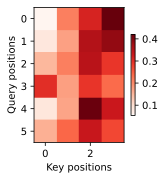

In [39]:
# Plus one to include the end-of-sequence token
d2l.show_heatmaps(
    attention_weights[:, :, :, :len(engs[-1].split()) + 1].cpu(),
    xlabel='Key positions', ylabel='Query positions')

#10.5. Multi-Head Attention

##10.5.1. Model

In [40]:
import math
import torch
from torch import nn
from d2l import torch as d2l

##10.5.2. Implementation

In [41]:
#@save
class MultiHeadAttention(nn.Module):
    """Multi-head attention."""
    def __init__(self, key_size, query_size, value_size, num_hiddens,
                 num_heads, dropout, bias=False, **kwargs):
        super(MultiHeadAttention, self).__init__(**kwargs)
        self.num_heads = num_heads
        self.attention = d2l.DotProductAttention(dropout)
        self.W_q = nn.Linear(query_size, num_hiddens, bias=bias)
        self.W_k = nn.Linear(key_size, num_hiddens, bias=bias)
        self.W_v = nn.Linear(value_size, num_hiddens, bias=bias)
        self.W_o = nn.Linear(num_hiddens, num_hiddens, bias=bias)

    def forward(self, queries, keys, values, valid_lens):
        # Shape of `queries`, `keys`, or `values`:
        # (`batch_size`, no. of queries or key-value pairs, `num_hiddens`)
        # Shape of `valid_lens`:
        # (`batch_size`,) or (`batch_size`, no. of queries)
        # After transposing, shape of output `queries`, `keys`, or `values`:
        # (`batch_size` * `num_heads`, no. of queries or key-value pairs,
        # `num_hiddens` / `num_heads`)
        queries = transpose_qkv(self.W_q(queries), self.num_heads)
        keys = transpose_qkv(self.W_k(keys), self.num_heads)
        values = transpose_qkv(self.W_v(values), self.num_heads)

        if valid_lens is not None:
            # On axis 0, copy the first item (scalar or vector) for
            # `num_heads` times, then copy the next item, and so on
            valid_lens = torch.repeat_interleave(
                valid_lens, repeats=self.num_heads, dim=0)

        # Shape of `output`: (`batch_size` * `num_heads`, no. of queries,
        # `num_hiddens` / `num_heads`)
        output = self.attention(queries, keys, values, valid_lens)

        # Shape of `output_concat`:
        # (`batch_size`, no. of queries, `num_hiddens`)
        output_concat = transpose_output(output, self.num_heads)
        return self.W_o(output_concat)

In [42]:
#@save
def transpose_qkv(X, num_heads):
    """Transposition for parallel computation of multiple attention heads."""
    # Shape of input `X`:
    # (`batch_size`, no. of queries or key-value pairs, `num_hiddens`).
    # Shape of output `X`:
    # (`batch_size`, no. of queries or key-value pairs, `num_heads`,
    # `num_hiddens` / `num_heads`)
    X = X.reshape(X.shape[0], X.shape[1], num_heads, -1)

    # Shape of output `X`:
    # (`batch_size`, `num_heads`, no. of queries or key-value pairs,
    # `num_hiddens` / `num_heads`)
    X = X.permute(0, 2, 1, 3)

    # Shape of `output`:
    # (`batch_size` * `num_heads`, no. of queries or key-value pairs,
    # `num_hiddens` / `num_heads`)
    return X.reshape(-1, X.shape[2], X.shape[3])


#@save
def transpose_output(X, num_heads):
    """Reverse the operation of `transpose_qkv`."""
    X = X.reshape(-1, num_heads, X.shape[1], X.shape[2])
    X = X.permute(0, 2, 1, 3)
    return X.reshape(X.shape[0], X.shape[1], -1)

In [43]:
num_hiddens, num_heads = 100, 5
attention = MultiHeadAttention(num_hiddens, num_hiddens, num_hiddens,
                               num_hiddens, num_heads, 0.5)
attention.eval()

MultiHeadAttention(
  (attention): DotProductAttention(
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (W_q): Linear(in_features=100, out_features=100, bias=False)
  (W_k): Linear(in_features=100, out_features=100, bias=False)
  (W_v): Linear(in_features=100, out_features=100, bias=False)
  (W_o): Linear(in_features=100, out_features=100, bias=False)
)

In [44]:
batch_size, num_queries, num_kvpairs, valid_lens = 2, 4, 6, torch.tensor([3, 2])
X = torch.ones((batch_size, num_queries, num_hiddens))
Y = torch.ones((batch_size, num_kvpairs, num_hiddens))
attention(X, Y, Y, valid_lens).shape

torch.Size([2, 4, 100])

#10.6. Self-Attention and Positional Encoding

In [45]:
import math
import torch
from torch import nn
from d2l import torch as d2l

##10.6.1. Self-Attention

In [46]:
num_hiddens, num_heads = 100, 5
attention = d2l.MultiHeadAttention(num_hiddens, num_hiddens, num_hiddens,
                                   num_hiddens, num_heads, 0.5)
attention.eval()

MultiHeadAttention(
  (attention): DotProductAttention(
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (W_q): Linear(in_features=100, out_features=100, bias=False)
  (W_k): Linear(in_features=100, out_features=100, bias=False)
  (W_v): Linear(in_features=100, out_features=100, bias=False)
  (W_o): Linear(in_features=100, out_features=100, bias=False)
)

In [47]:
batch_size, num_queries, valid_lens = 2, 4, torch.tensor([3, 2])
X = torch.ones((batch_size, num_queries, num_hiddens))
attention(X, X, X, valid_lens).shape

torch.Size([2, 4, 100])

##10.6.3. Positional Encoding

In [48]:
#@save
class PositionalEncoding(nn.Module):
    """Positional encoding."""
    def __init__(self, num_hiddens, dropout, max_len=1000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(dropout)
        # Create a long enough `P`
        self.P = torch.zeros((1, max_len, num_hiddens))
        X = torch.arange(max_len, dtype=torch.float32).reshape(
            -1, 1) / torch.pow(10000, torch.arange(
            0, num_hiddens, 2, dtype=torch.float32) / num_hiddens)
        self.P[:, :, 0::2] = torch.sin(X)
        self.P[:, :, 1::2] = torch.cos(X)

    def forward(self, X):
        X = X + self.P[:, :X.shape[1], :].to(X.device)
        return self.dropout(X)

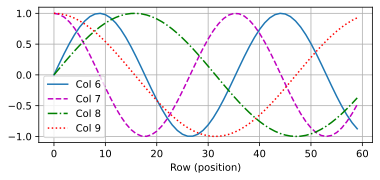

In [49]:
encoding_dim, num_steps = 32, 60
pos_encoding = PositionalEncoding(encoding_dim, 0)
pos_encoding.eval()
X = pos_encoding(torch.zeros((1, num_steps, encoding_dim)))
P = pos_encoding.P[:, :X.shape[1], :]
d2l.plot(torch.arange(num_steps), P[0, :, 6:10].T, xlabel='Row (position)',
         figsize=(6, 2.5), legend=["Col %d" % d for d in torch.arange(6, 10)])

###10.6.3.1. Absolute Positional Information

In [50]:
for i in range(8):
    print(f'{i} in binary is {i:>03b}')

0 in binary is 000
1 in binary is 001
2 in binary is 010
3 in binary is 011
4 in binary is 100
5 in binary is 101
6 in binary is 110
7 in binary is 111


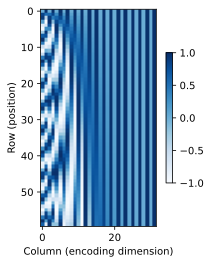

In [51]:
P = P[0, :, :].unsqueeze(0).unsqueeze(0)
d2l.show_heatmaps(P, xlabel='Column (encoding dimension)',
                  ylabel='Row (position)', figsize=(3.5, 4), cmap='Blues')

#10.7. Transformer

##10.7.1. Model

In [52]:
import math
import pandas as pd
import torch
from torch import nn
from d2l import torch as d2l

##10.7.2. Positionwise Feed-Forward Networks

In [53]:
#@save
class PositionWiseFFN(nn.Module):
    """Positionwise feed-forward network."""
    def __init__(self, ffn_num_input, ffn_num_hiddens, ffn_num_outputs,
                 **kwargs):
        super(PositionWiseFFN, self).__init__(**kwargs)
        self.dense1 = nn.Linear(ffn_num_input, ffn_num_hiddens)
        self.relu = nn.ReLU()
        self.dense2 = nn.Linear(ffn_num_hiddens, ffn_num_outputs)

    def forward(self, X):
        return self.dense2(self.relu(self.dense1(X)))

In [54]:
ffn = PositionWiseFFN(4, 4, 8)
ffn.eval()
ffn(torch.ones((2, 3, 4)))[0]

tensor([[-0.0520,  0.0688,  0.6514,  0.1758,  0.1349, -0.3702, -0.3764, -0.3847],
        [-0.0520,  0.0688,  0.6514,  0.1758,  0.1349, -0.3702, -0.3764, -0.3847],
        [-0.0520,  0.0688,  0.6514,  0.1758,  0.1349, -0.3702, -0.3764, -0.3847]],
       grad_fn=<SelectBackward0>)

##10.7.3. Residual Connection and Layer Normalization

In [55]:
ln = nn.LayerNorm(2)
bn = nn.BatchNorm1d(2)
X = torch.tensor([[1, 2], [2, 3]], dtype=torch.float32)
# Compute mean and variance from `X` in the training mode
print('layer norm:', ln(X), '\nbatch norm:', bn(X))

layer norm: tensor([[-1.0000,  1.0000],
        [-1.0000,  1.0000]], grad_fn=<NativeLayerNormBackward0>) 
batch norm: tensor([[-1.0000, -1.0000],
        [ 1.0000,  1.0000]], grad_fn=<NativeBatchNormBackward0>)


In [56]:
#@save
class AddNorm(nn.Module):
    """Residual connection followed by layer normalization."""
    def __init__(self, normalized_shape, dropout, **kwargs):
        super(AddNorm, self).__init__(**kwargs)
        self.dropout = nn.Dropout(dropout)
        self.ln = nn.LayerNorm(normalized_shape)

    def forward(self, X, Y):
        return self.ln(self.dropout(Y) + X)

In [57]:
add_norm = AddNorm([3, 4], 0.5) # Normalized_shape is input.size()[1:]
add_norm.eval()
add_norm(torch.ones((2, 3, 4)), torch.ones((2, 3, 4))).shape

torch.Size([2, 3, 4])

##10.7.4. Encoder

In [58]:
#@save
class EncoderBlock(nn.Module):
    """Transformer encoder block."""
    def __init__(self, key_size, query_size, value_size, num_hiddens,
                 norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
                 dropout, use_bias=False, **kwargs):
        super(EncoderBlock, self).__init__(**kwargs)
        self.attention = d2l.MultiHeadAttention(
            key_size, query_size, value_size, num_hiddens, num_heads, dropout,
            use_bias)
        self.addnorm1 = AddNorm(norm_shape, dropout)
        self.ffn = PositionWiseFFN(
            ffn_num_input, ffn_num_hiddens, num_hiddens)
        self.addnorm2 = AddNorm(norm_shape, dropout)

    def forward(self, X, valid_lens):
        Y = self.addnorm1(X, self.attention(X, X, X, valid_lens))
        return self.addnorm2(Y, self.ffn(Y))

In [59]:
X = torch.ones((2, 100, 24))
valid_lens = torch.tensor([3, 2])
encoder_blk = EncoderBlock(24, 24, 24, 24, [100, 24], 24, 48, 8, 0.5)
encoder_blk.eval()
encoder_blk(X, valid_lens).shape

torch.Size([2, 100, 24])

In [60]:
#@save
class TransformerEncoder(d2l.Encoder):
    """Transformer encoder."""
    def __init__(self, vocab_size, key_size, query_size, value_size,
                 num_hiddens, norm_shape, ffn_num_input, ffn_num_hiddens,
                 num_heads, num_layers, dropout, use_bias=False, **kwargs):
        super(TransformerEncoder, self).__init__(**kwargs)
        self.num_hiddens = num_hiddens
        self.embedding = nn.Embedding(vocab_size, num_hiddens)
        self.pos_encoding = d2l.PositionalEncoding(num_hiddens, dropout)
        self.blks = nn.Sequential()
        for i in range(num_layers):
            self.blks.add_module("block"+str(i),
                EncoderBlock(key_size, query_size, value_size, num_hiddens,
                             norm_shape, ffn_num_input, ffn_num_hiddens,
                             num_heads, dropout, use_bias))

    def forward(self, X, valid_lens, *args):
        # Since positional encoding values are between -1 and 1, the embedding
        # values are multiplied by the square root of the embedding dimension
        # to rescale before they are summed up
        X = self.pos_encoding(self.embedding(X) * math.sqrt(self.num_hiddens))
        self.attention_weights = [None] * len(self.blks)
        for i, blk in enumerate(self.blks):
            X = blk(X, valid_lens)
            self.attention_weights[
                i] = blk.attention.attention.attention_weights
        return X

In [61]:
encoder = TransformerEncoder(
    200, 24, 24, 24, 24, [100, 24], 24, 48, 8, 2, 0.5)
encoder.eval()
encoder(torch.ones((2, 100), dtype=torch.long), valid_lens).shape

torch.Size([2, 100, 24])

##10.7.5. Decoder

In [62]:
class DecoderBlock(nn.Module):
    # The `i`-th block in the decoder
    def __init__(self, key_size, query_size, value_size, num_hiddens,
                 norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
                 dropout, i, **kwargs):
        super(DecoderBlock, self).__init__(**kwargs)
        self.i = i
        self.attention1 = d2l.MultiHeadAttention(
            key_size, query_size, value_size, num_hiddens, num_heads, dropout)
        self.addnorm1 = AddNorm(norm_shape, dropout)
        self.attention2 = d2l.MultiHeadAttention(
            key_size, query_size, value_size, num_hiddens, num_heads, dropout)
        self.addnorm2 = AddNorm(norm_shape, dropout)
        self.ffn = PositionWiseFFN(ffn_num_input, ffn_num_hiddens,
                                   num_hiddens)
        self.addnorm3 = AddNorm(norm_shape, dropout)

    def forward(self, X, state):
        enc_outputs, enc_valid_lens = state[0], state[1]
        # During training, all the tokens of any output sequence are processed
        # at the same time, so `state[2][self.i]` is `None` as initialized.
        # When decoding any output sequence token by token during prediction,
        # `state[2][self.i]` contains representations of the decoded output at
        # the `i`-th block up to the current time step
        if state[2][self.i] is None:
            key_values = X
        else:
            key_values = torch.cat((state[2][self.i], X), axis=1)
        state[2][self.i] = key_values
        if self.training:
            batch_size, num_steps, _ = X.shape
            # Shape of `dec_valid_lens`: (`batch_size`, `num_steps`), where
            # every row is [1, 2, ..., `num_steps`]
            dec_valid_lens = torch.arange(
                1, num_steps + 1, device=X.device).repeat(batch_size, 1)
        else:
            dec_valid_lens = None

        # Self-attention
        X2 = self.attention1(X, key_values, key_values, dec_valid_lens)
        Y = self.addnorm1(X, X2)
        # Encoder-decoder attention. Shape of `enc_outputs`:
        # (`batch_size`, `num_steps`, `num_hiddens`)
        Y2 = self.attention2(Y, enc_outputs, enc_outputs, enc_valid_lens)
        Z = self.addnorm2(Y, Y2)
        return self.addnorm3(Z, self.ffn(Z)), state

In [63]:
decoder_blk = DecoderBlock(24, 24, 24, 24, [100, 24], 24, 48, 8, 0.5, 0)
decoder_blk.eval()
X = torch.ones((2, 100, 24))
state = [encoder_blk(X, valid_lens), valid_lens, [None]]
decoder_blk(X, state)[0].shape

torch.Size([2, 100, 24])

In [64]:
class TransformerDecoder(d2l.AttentionDecoder):
    def __init__(self, vocab_size, key_size, query_size, value_size,
                 num_hiddens, norm_shape, ffn_num_input, ffn_num_hiddens,
                 num_heads, num_layers, dropout, **kwargs):
        super(TransformerDecoder, self).__init__(**kwargs)
        self.num_hiddens = num_hiddens
        self.num_layers = num_layers
        self.embedding = nn.Embedding(vocab_size, num_hiddens)
        self.pos_encoding = d2l.PositionalEncoding(num_hiddens, dropout)
        self.blks = nn.Sequential()
        for i in range(num_layers):
            self.blks.add_module("block"+str(i),
                DecoderBlock(key_size, query_size, value_size, num_hiddens,
                             norm_shape, ffn_num_input, ffn_num_hiddens,
                             num_heads, dropout, i))
        self.dense = nn.Linear(num_hiddens, vocab_size)

    def init_state(self, enc_outputs, enc_valid_lens, *args):
        return [enc_outputs, enc_valid_lens, [None] * self.num_layers]

    def forward(self, X, state):
        X = self.pos_encoding(self.embedding(X) * math.sqrt(self.num_hiddens))
        self._attention_weights = [[None] * len(self.blks) for _ in range (2)]
        for i, blk in enumerate(self.blks):
            X, state = blk(X, state)
            # Decoder self-attention weights
            self._attention_weights[0][
                i] = blk.attention1.attention.attention_weights
            # Encoder-decoder attention weights
            self._attention_weights[1][
                i] = blk.attention2.attention.attention_weights
        return self.dense(X), state

    @property
    def attention_weights(self):
        return self._attention_weights

##10.7.6. Training

loss 0.031, 3494.1 tokens/sec on cpu


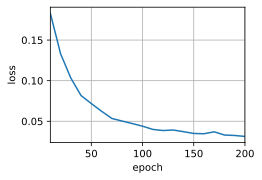

In [65]:
num_hiddens, num_layers, dropout, batch_size, num_steps = 32, 2, 0.1, 64, 10
lr, num_epochs, device = 0.005, 200, d2l.try_gpu()
ffn_num_input, ffn_num_hiddens, num_heads = 32, 64, 4
key_size, query_size, value_size = 32, 32, 32
norm_shape = [32]

train_iter, src_vocab, tgt_vocab = d2l.load_data_nmt(batch_size, num_steps)

encoder = TransformerEncoder(
    len(src_vocab), key_size, query_size, value_size, num_hiddens,
    norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
    num_layers, dropout)
decoder = TransformerDecoder(
    len(tgt_vocab), key_size, query_size, value_size, num_hiddens,
    norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
    num_layers, dropout)
net = d2l.EncoderDecoder(encoder, decoder)
d2l.train_seq2seq(net, train_iter, lr, num_epochs, tgt_vocab, device)

In [66]:
engs = ['go .', "i lost .", 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']
for eng, fra in zip(engs, fras):
    translation, dec_attention_weight_seq = d2l.predict_seq2seq(
        net, eng, src_vocab, tgt_vocab, num_steps, device, True)
    print(f'{eng} => {translation}, ',
          f'bleu {d2l.bleu(translation, fra, k=2):.3f}')

go . => va !,  bleu 1.000
i lost . => je m'en <unk> .,  bleu 0.000
he's calm . => il est paresseux .,  bleu 0.658
i'm home . => je suis chez moi .,  bleu 1.000


In [67]:
enc_attention_weights = torch.cat(net.encoder.attention_weights, 0).reshape((num_layers, num_heads,
    -1, num_steps))
enc_attention_weights.shape

torch.Size([2, 4, 10, 10])

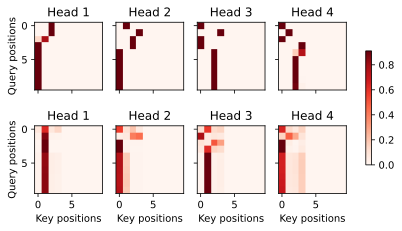

In [68]:
d2l.show_heatmaps(
    enc_attention_weights.cpu(), xlabel='Key positions',
    ylabel='Query positions', titles=['Head %d' % i for i in range(1, 5)],
    figsize=(7, 3.5))

In [69]:
dec_attention_weights_2d = [head[0].tolist()
                            for step in dec_attention_weight_seq
                            for attn in step for blk in attn for head in blk]
dec_attention_weights_filled = torch.tensor(
    pd.DataFrame(dec_attention_weights_2d).fillna(0.0).values)
dec_attention_weights = dec_attention_weights_filled.reshape((-1, 2, num_layers, num_heads, num_steps))
dec_self_attention_weights, dec_inter_attention_weights = \
    dec_attention_weights.permute(1, 2, 3, 0, 4)
dec_self_attention_weights.shape, dec_inter_attention_weights.shape

(torch.Size([2, 4, 6, 10]), torch.Size([2, 4, 6, 10]))

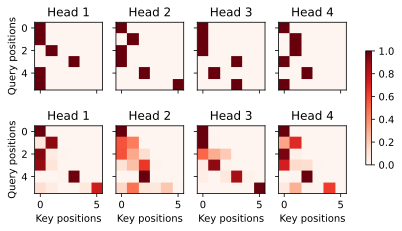

In [70]:
# Plus one to include the beginning-of-sequence token
d2l.show_heatmaps(
    dec_self_attention_weights[:, :, :, :len(translation.split()) + 1],
    xlabel='Key positions', ylabel='Query positions',
    titles=['Head %d' % i for i in range(1, 5)], figsize=(7, 3.5))

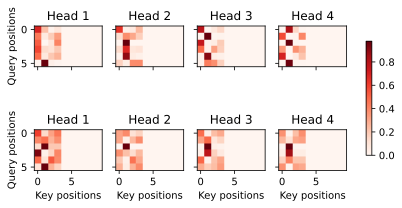

In [71]:
d2l.show_heatmaps(
    dec_inter_attention_weights, xlabel='Key positions',
    ylabel='Query positions', titles=['Head %d' % i for i in range(1, 5)],
    figsize=(7, 3.5))